<a href="https://colab.research.google.com/github/ramdarsh/Excelr_assignments/blob/main/Recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BOOKS

In [1]:
!pip install scikit-surprise

In [2]:
import numpy as np
import pandas as pd
import surprise
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv("/content/book.csv",encoding = "ISO-8859-1")

In [4]:
df1 = df.iloc[:,1:]

In [5]:
df1.columns = ['userID', 'title', 'bookRating']

In [6]:
df1.head()

,userID,title,bookRating
0,276726,Classical Mythology,5
1,276729,Clara Callan,3
2,276729,Decision in Normandy,6
3,276736,Flu: The Story of the Great Influenza Pandemic...,8
4,276737,The Mummies of Urumchi,6


In [7]:
print('# of records: %d\n# of books: %d\n# of users: %d' % (len(df1), len(df1['title'].unique()), len(df1['userID'].unique())))


# of records: 10000
# of books: 9659
# of users: 2182


In [8]:
palette = sns.color_palette("RdBu", 10)

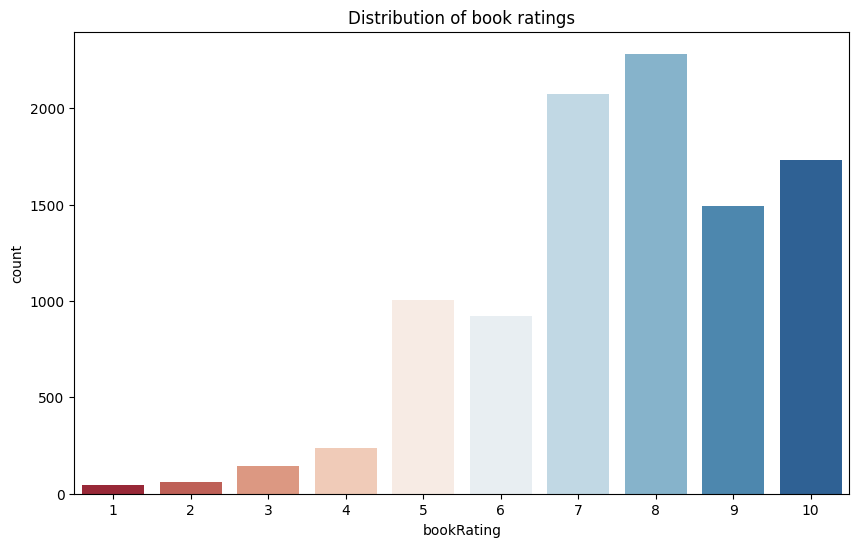

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='bookRating', data=df1, palette=palette)
ax.set_title('Distribution of book ratings')

plt.show()

In [10]:
df1.bookRating.unique()

array([ 5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [11]:
reader = surprise.Reader(rating_scale=(1, 10))

In [12]:
data = surprise.Dataset.load_from_df(df1[['userID', 'title', 'bookRating']], reader)

In [13]:
trainset, testset = train_test_split(data, test_size=.20)

In [14]:
benchmark = []

In [ ]:
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), BaselineOnly(), CoClustering()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [16]:
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.682185,0.970974,0.110154
SVD,1.688429,0.185303,0.029334
BaselineOnly,1.705413,0.100279,0.036328
KNNBaseline,1.706731,0.185325,0.116328
SlopeOne,1.819742,0.934271,0.048067
KNNWithMeans,1.820525,0.148667,0.080247
KNNBasic,1.824245,0.107249,0.135202
CoClustering,1.851849,1.920874,0.041201
NMF,1.895977,1.717179,0.037070


**USING SVD ALGORITHM**

In [17]:
algo = SVD()

In [18]:
algo.fit(trainset)

In [19]:
predictions = algo.test(testset)

In [20]:
accuracy.rmse(predictions, verbose=True)

RMSE: 1.6905


1.6904795283379137

In [21]:
def recommendation(userID):
    user = df1.copy()
    already_read = df1[df1['userID'] == userID]['title'].unique()
    user = user.reset_index()
    user = user[~user['title'].isin(already_read)]
    user['Estimate_Score']=user['title'].apply(lambda x: algo.predict(userID, x).est)
    user = user.sort_values('Estimate_Score', ascending=False)
    print(user.head(10))

In [22]:
rating = pd.pivot_table(df1, index='userID', values='bookRating', columns='title', fill_value=0)

In [24]:
corr = np.corrcoef(rating.T)

In [25]:
corr.shape

(9659, 9659)

In [26]:
book_list=  list(rating)

In [27]:
book_titles =[]

In [28]:
for i in range(len(book_list)):
    book_titles.append(book_list[i])

In [ ]:
book_titles

In [31]:
def get_recommendation(books_list):
    book_similarities = np.zeros(corr.shape[0])

    for book in books_list:
        book_index = book_titles.index(book)
        book_similarities += corr[book_index]
        book_preferences = []
    for i in range(len(book_titles)):
        book_preferences.append((book_titles[i],book_similarities[i]))

    return sorted(book_preferences, key= lambda x: x[1], reverse=True)

In [32]:
recommendation(276747)

      index  userID                                              title  \
2687   2687     254      Karen's Doll (Baby-Sitters Little Sister, 23)   
6306   6306    3194                                          Dog Brain   
2300   2300  278694  The Pilates Body: The Ultimate At-Home Guide t...   
6124   6124    2977  Daniel  (Return To Calloway Corners) (Harlequi...   
2129   2129  278552                                    Now You See Her   
8222   8222    4225                                       Tiger Prince   
5670   5670    2520                                       Tiger Prince   
6662   6662    3404  Martina: The Lives and Times of Martina Navrat...   
6277   6277    3167                              Creativity is forever   
1288   1288  277928      The Curse of Madame C : A Far Side Collection   

      bookRating  Estimate_Score  
2687          10        8.171313  
6306          10        8.153760  
2300          10        8.143272  
6124          10        8.127448  
2129      

In [33]:
my_fav_books = ['Classical Mythology','Clara Callan']

In [34]:
print('The books you might like: \n' , get_recommendation(my_fav_books)[:10])

The books you might like: 
 [('Clara Callan', 0.9995414947271893), ('Classical Mythology', 0.9995414947271893), ('Decision in Normandy', 0.9995414947271893), ('A Wrinkle In Time', -0.0009170105456212509), ('Are You My Mommy?', -0.0009170105456212509), ('Driven With the Wind (Cheney Duvall MP, 8)', -0.0009170105456212509), ('Friendship: Skills for Having a Friend, Being a Friend', -0.0009170105456212509), ('Island of the Innocent (Cheney Duval, M.D., 7)', -0.0009170105456212509), ('Jane Eyre (Penguin Classics)', -0.0009170105456212509), ('LITTLE BIRDS', -0.0009170105456212509)]
